In [6]:
#import json
#import time
#import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
#from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
#from qiskit.utils import algorithm_globals

#from qiskit_machine_learning.circuit.library import RawFeatureVector
#from qiskit_machine_learning.neural_networks import SamplerQNN

#set seed for pseudorandom number generator
#algorithm_globals.random_seed = 42

Costruisco circuito parametrico ("ansatz"). Questo applica allo stato iniziale una trasformazione unitaria tale per cui lo stato può essere intrecciato in modi diversi a seconda del vettore di parametri del circuito.

In [2]:
def AnsatzBuilder(QubitNumber, Depth):
    return RealAmplitudes(QubitNumber, reps=Depth)

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


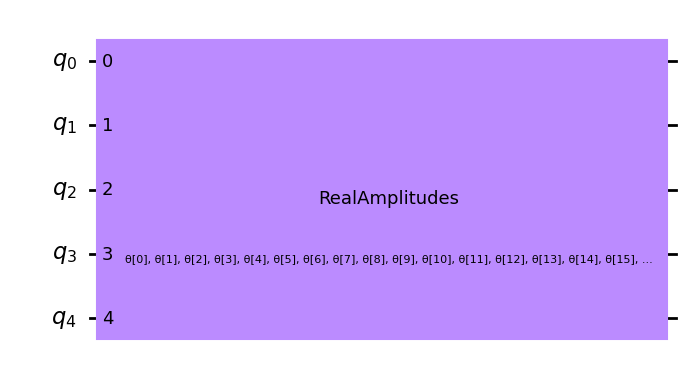

In [8]:
Ansatz = AnsatzBuilder(5,5)
Ansatz.draw("mpl")

Costruisco lo Swaptest. Si tratta di un circuito che ha come output una misura della probabilità che lo stato dei qubit trash sia |0,...,0>.

In [25]:
def SwaptestBuilder(TrashSpaceDimension):
    QubitNumber = 2*TrashSpaceDimension + 1
    QuantReg = QuantumRegister(QubitNumber,"q")
    ClassReg = ClassicalRegister(1,"c")
    SwaptestCircuit = QuantumCircuit(QuantReg, ClassReg)
    AuxiliaryQubitLable = QubitNumber-1
    
    #INITIALIZE REFERENCE QUBITS TO 0
    for i in range(TrashSpaceDimension,2*TrashSpaceDimension): SwaptestCircuit.reset(i)

    #H GATE ON AUXILIARY QUBIT
    SwaptestCircuit.h(AuxiliaryQubitLable)
    #CSWAP GATES BETWEEN TRASH AND REFERENCE QUBITS TARGETING AUXILIARY QUBIT
    for i in range(TrashSpaceDimension):
        SwaptestCircuit.cswap(AuxiliaryQubitLable, i, TrashSpaceDimension+i)
    #H GATE ON AUXILIARY QUBIT
    SwaptestCircuit.h(AuxiliaryQubitLable)
    SwaptestCircuit.measure(AuxiliaryQubitLable, ClassReg[0])

    return SwaptestCircuit


/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


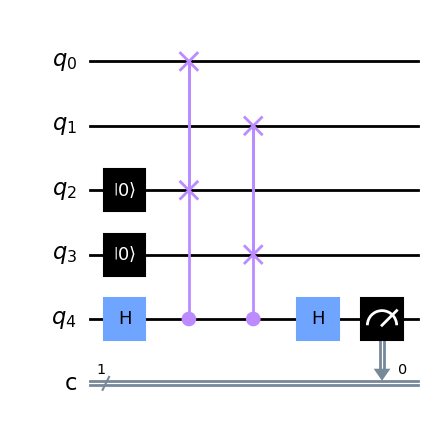

In [24]:
Swaptest = SwaptestBuilder(2)
Swaptest.draw("mpl")

Costruisco l'encoder combinando i due circuiti precedenti

In [4]:
def EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth):
    #Calculate dimension of spaces
    LatentSpaceDimension = EncodedStateDimension
    TrashSpaceDimension = InputStateDimension - EncodedStateDimension
    ReferenceSpaceDimension = TrashSpaceDimension
    TotalQubitNumber = LatentSpaceDimension + TrashSpaceDimension + ReferenceSpaceDimension +1 #+1 (for auxiliary qubit)

    #Initialize circuit
    QuantReg = QuantumRegister(TotalQubitNumber,"q")
    ClassReg = ClassicalRegister(1,"c")
    Circuit = QuantumCircuit(QuantReg, ClassReg)

    #Add AnsatzCircuit
    Circuit.compose(AnsatzBuilder(LatentSpaceDimension+TrashSpaceDimension, Depth),range(0, InputStateDimension), inplace=True)
    #Barrier to define optimization regions
    Circuit.barrier()
    #Add SwapTestCircuit
    Circuit.compose(SwaptestBuilder(TrashSpaceDimension),range(LatentSpaceDimension, TotalQubitNumber), inplace=True)
    
    return Circuit


/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


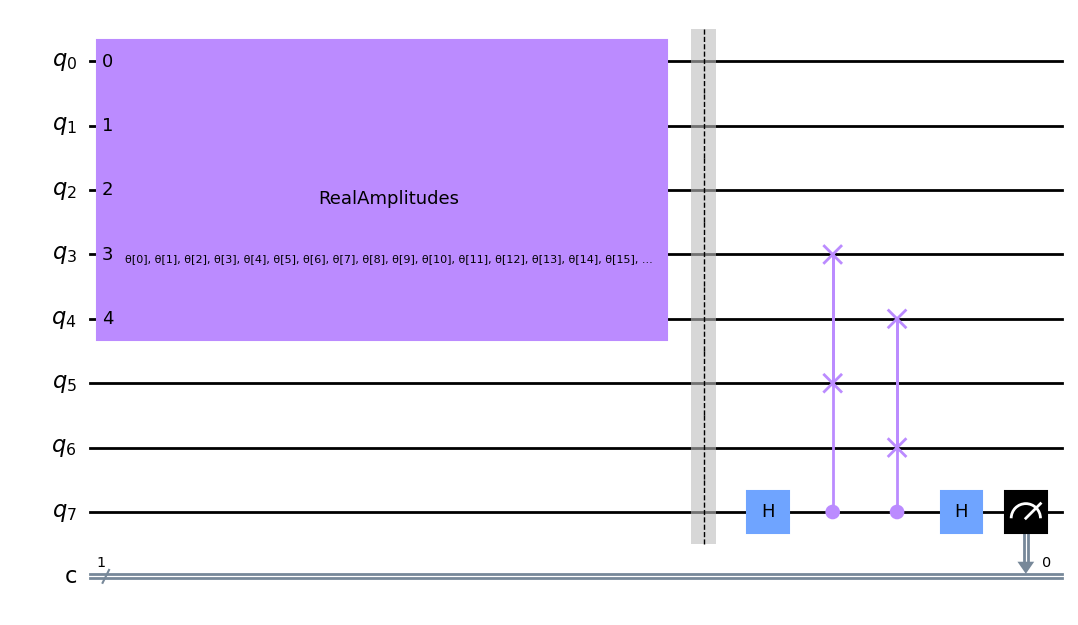

In [5]:
Encoder = EncoderBuilder(5,3,5)
Encoder.draw("mpl")